In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams.update({'font.size':20})
plt.rcParams["figure.figsize"] = (12,10)

In [24]:
str_files = ''
#Carrega os dados do arquivo .csv
df_ugrhi06 = pd.read_csv(str_files + "cetesb_concatenado06semoutliers.csv",encoding='utf-8',sep=',',index_col=[0])

#Carrega os dados do arquivo .csv
df_ugrhi10 = pd.read_csv(str_files + "cetesb_concatenado10semoutliers.csv",encoding='utf-8',sep=',',index_col=[0])
#Carrega os dados do arquivo .csv
df_ugrhi10

,solido,ph,coliformes,dbo,fosforo,od,temperatura,turbidez
1978-01-31,189.791667,7.094057,3535.833333,4.916667,1.084160,2.471667,21.791667,27.641667
1978-02-28,192.118607,7.105961,3439.495434,4.788813,1.084160,2.442676,21.951484,27.898333
1978-03-31,194.694863,7.105961,3332.835616,4.647260,1.084160,2.410579,22.128425,28.182500
1978-04-30,197.188014,7.120679,3229.616438,4.510274,1.084160,2.379517,22.299658,28.457500
1978-05-31,199.764269,7.120679,3122.956621,4.368721,1.084160,2.347420,22.476598,28.741667
...,...,...,...,...,...,...,...,...
2019-06-30,361.506122,7.136287,5700.000000,7.481633,0.197539,3.799184,24.995918,28.922449
2019-07-31,345.626531,7.136287,5700.000000,8.620408,0.195135,3.849796,25.248980,33.730612
2019-08-31,329.746939,7.206898,5700.000000,9.759184,0.192731,3.900408,25.502041,38.538776
2019-09-30,314.379592,7.134653,5700.000000,10.861224,0.190404,3.949388,25.746939,43.191837


In [25]:
print('---- Tamanho dos conjuntos originais ----')
print('ugrhi06:',len(df_ugrhi06))
print('ugrhi10:',len(df_ugrhi10))

#Seleciona os dados equivalente ao tamanho da URGHI10
df_ugrhi06 = df_ugrhi06.iloc[0:len(df_ugrhi10)]

#Seleciona os valores da coluna ph da URGHI06, na qual será utilizado para a normalização dos dados quando apresentar o gráfico
#train_previsao = ugrhi06['ph'].values
#train_previsao = train_previsao.reshape(len(train_previsao),1)

print('---- Conjunto de dados y igualado ao tamanho de dados do conjunto X ----')
print('ugrhi06:',len(df_ugrhi06))
print('ugrhi10:',len(df_ugrhi10))

---- Tamanho dos conjuntos originais ----
ugrhi06: 503
ugrhi10: 502
---- Conjunto de dados y igualado ao tamanho de dados do conjunto X ----
ugrhi06: 502
ugrhi10: 502


In [26]:
# OBS.: O parâmetro temperatura não possui correlação suficiente para este tipo de experimento.
def seleciona_colunas(trainingd,p,ugrhi):
    
    posicao_coluna = 0
    frame_completo = pd.DataFrame()
    
    if (ugrhi == 6):
            
        if (p == 'ph'):
            fcoliformes = trainingd.iloc[:,1:2].values
            fdbo        = trainingd.iloc[:,2:3].values
            fph         = trainingd.iloc[:,0:1].values
            fsolido     = trainingd.iloc[:,5:6].values

            frame_completo = pd.DataFrame(list(zip(fcoliformes,fdbo,fsolido,fph)),columns =['coliformes','dbo','solido','ph']) 
            posicao_coluna = 3

        elif (p == 'od'):
            fod      = trainingd.iloc[:,4:5].values
            fsolido  = trainingd.iloc[:,5:6].values

            frame_completo = pd.DataFrame(list(zip(fsolido,fod)),columns =['solido','od']) 
            posicao_coluna = 1

        elif (p == 'coliformes'):
            fph          = trainingd.iloc[:,0:1].values
            fcoliformes  = trainingd.iloc[:,1:2].values

            frame_completo = pd.DataFrame(list(zip(fph,fcoliformes)),columns =['ph','coliformes']) 
            posicao_coluna = 1

        elif (p == 'dbo'):
            #ph, fosforo, solido tem correlação com o dbo
            fph      = trainingd.iloc[:,0:1].values
            fdbo     = trainingd.iloc[:,2:3].values
            ffosforo = trainingd.iloc[:,3:4].values
            fsolido  = trainingd.iloc[:,5:6].values

            frame_completo = pd.DataFrame(list(zip(fph,ffosforo,fsolido,fdbo)),columns =['ph','fosforo','solido','dbo']) 
            posicao_coluna = 3

        elif (p == 'fosforo'):
            # dbo e solido tem correlação com o fosforo
            fdbo     = trainingd.iloc[:,2:3].values
            ffosforo = trainingd.iloc[:,3:4].values
            fsolido  = trainingd.iloc[:,5:6].values

            frame_completo = pd.DataFrame(list(zip(fdbo,fsolido,ffosforo)),columns =['dbo','solido','fosforo']) 
            posicao_coluna = 2

        elif (p == 'solido'):
            # ph, dbo, fosforo, od, solido e turbidez tem correlação com o solido
            fph        = trainingd.iloc[:,0:1].values
            fdbo       = trainingd.iloc[:,2:3].values
            ffosforo   = trainingd.iloc[:,3:4].values
            fod        = trainingd.iloc[:,4:5].values
            fsolido    = trainingd.iloc[:,5:6].values
            fturbidez  = trainingd.iloc[:,7:8].values

            frame_completo = pd.DataFrame(list(zip(fph,fdbo,ffosforo,fod,fturbidez,fsolido)),
                                      columns =['ph','dbo','fosforo','od','turidez','solido']) 
            posicao_coluna = 5

        elif (p == 'turbidez'):
            # solido e turbidez tem correlação com o turbidez

            fsolido    = trainingd.iloc[:,5:6].values
            fturbidez  = trainingd.iloc[:,7:8].values

            frame_completo = pd.DataFrame(list(zip(fsolido,fturbidez)),columns =['solido','turidez']) 
            posicao_coluna = 1
        
    elif (ugrhi == 10):
        
        if (p == 'ph'):
            fcoliformes = trainingd.iloc[:,2:3].values
            fdbo        = trainingd.iloc[:,3:4].values
            fph         = trainingd.iloc[:,1:2].values
            fsolido     = trainingd.iloc[:,0:1].values

            frame_completo = pd.DataFrame(list(zip(fcoliformes,fdbo,fsolido,fph)),columns =['coliformes','dbo','solido','ph']) 
            posicao_coluna = 3

        elif (p == 'od'):
            fod      = trainingd.iloc[:,5:6].values
            fsolido  = trainingd.iloc[:,0:1].values

            frame_completo = pd.DataFrame(list(zip(fsolido,fod)),columns =['solido','od']) 
            posicao_coluna = 1

        elif (p == 'coliformes'):
            fph          = trainingd.iloc[:,1:2].values
            fcoliformes  = trainingd.iloc[:,2:3].values

            frame_completo = pd.DataFrame(list(zip(fph,fcoliformes)),columns =['ph','coliformes']) 
            posicao_coluna = 1

        elif (p == 'dbo'):
            #ph, fosforo, solido tem correlação com o dbo
            fph      = trainingd.iloc[:,1:2].values
            fdbo     = trainingd.iloc[:,3:4].values
            ffosforo = trainingd.iloc[:,4:5].values
            fsolido  = trainingd.iloc[:,0:1].values

            frame_completo = pd.DataFrame(list(zip(fph,ffosforo,fsolido,fdbo)),columns =['ph','fosforo','solido','dbo']) 
            posicao_coluna = 3

        elif (p == 'fosforo'):
            # dbo e solido tem correlação com o fosforo
            fdbo     = trainingd.iloc[:,3:4].values
            ffosforo = trainingd.iloc[:,4:5].values
            fsolido  = trainingd.iloc[:,0:1].values

            frame_completo = pd.DataFrame(list(zip(fdbo,fsolido,ffosforo)),columns =['dbo','solido','fosforo']) 
            posicao_coluna = 2

        elif (p == 'solido'):
            # ph, dbo, fosforo, od, solido e turbidez tem correlação com o solido
            fph        = trainingd.iloc[:,1:2].values
            fdbo       = trainingd.iloc[:,3:4].values
            ffosforo   = trainingd.iloc[:,4:5].values
            fod        = trainingd.iloc[:,5:6].values
            fsolido    = trainingd.iloc[:,0:1].values
            fturbidez  = trainingd.iloc[:,7:8].values

            frame_completo = pd.DataFrame(list(zip(fph,fdbo,ffosforo,fod,fturbidez,fsolido)),
                                      columns =['ph','dbo','fosforo','od','turidez','solido']) 
            posicao_coluna = 5

        elif (p == 'turbidez'):
            # solido e turbidez tem correlação com o turbidez

            fsolido    = trainingd.iloc[:,0:1].values
            fturbidez  = trainingd.iloc[:,7:8].values

            frame_completo = pd.DataFrame(list(zip(fsolido,fturbidez)),columns =['solido','turidez']) 
            posicao_coluna = 1
        
    return frame_completo,posicao_coluna


'''
def seleciona_colunas(trainingd,ug):
   
    if (ug == 6):
        fdbo     = trainingd.iloc[:,2:3].values
        fph      = trainingd.iloc[:,0:1].values
        fsolido  = trainingd.iloc[:,5:6].values
   
        frame_completo = pd.DataFrame(list(zip(fdbo,fsolido,fph)),columns =['dbo','solido','ph'])
    else:
        fdbo     = trainingd.iloc[:,3:4].values
        fph      = trainingd.iloc[:,1:2].values
        fsolido  = trainingd.iloc[:,0:1].values
   
        frame_completo = pd.DataFrame(list(zip(fdbo,fsolido,fph)),columns =['dbo','solido','ph'])
       
   
    return frame_completo

def seleciona_colunas_od(trainingd,ug):
   
    if (ug == 6):
        fdbo     = trainingd.iloc[:,2:3].values
        fod      = trainingd.iloc[:,4:5].values
        fsolido  = trainingd.iloc[:,5:6].values
   
        frame_completo = pd.DataFrame(list(zip(fdbo,fsolido,fod)),columns =['dbo','solido','od'])
    else:
        fdbo     = trainingd.iloc[:,3:4].values
        fod      = trainingd.iloc[:,5:6].values
        fsolido  = trainingd.iloc[:,0:1].values
   
        frame_completo = pd.DataFrame(list(zip(fdbo,fsolido,fod)),columns =['dbo','solido','od'])
       
   
    return frame_completo
'''

def pegar_dados_coluna_predita_train_test(trainingd,percent,index_coluna):
    data = trainingd.iloc[:,:].values
    train = trainingd.iloc[0:int(len(data)*percent),:].values  
    train_previsao = trainingd.iloc[0:int(len(data)*percent),index_coluna:index_coluna+1].values
    test = trainingd.iloc[len(train):,index_coluna:index_coluna+1].values
    
    return train,train_previsao, test

#Normalização dos dados: Normaliza os dados dentro um intervalo (0 a 1).
def normalizacao(train,test):
    sc = MinMaxScaler()
    testd = test
    train = sc.fit_transform(train)
    test = sc.fit_transform(test)    
    return train,test,testd

#Prepara o conjunto de dados em X e y, considerando a janela de visualização (lags).
#cy = coluna que será predita
def prepara_dados(dados,lags,cy):
    X = []
    y = []
    for i in range(lags, len(dados)):
        X.append(dados[i-lags:i,:])
        y.append(dados[i, cy])
       
    return np.array(X), np.array(y)

#Calcula o MAPE
#Define função para calcular o MAPE
#def mape(y_pred,y_true):
 #   return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mape(y_pred,y_true):
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    '''  
    mape_sum = 0
    for real,prediction in zip(y_true,y_pred):
        mape_sum += (abs((real - prediction))/real)
        
        print(real)
        mape = mape_sum/len(real)
    '''
    return mape

def rmse(y_pred,y_true):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    return rmse

def r2(y_pred,y_true):
    rscore = r2_score(y_true,y_pred)
    return rscore

def rquadrado(y_pred,y_true):
    #Soma Total dos Quadrados (STQ): mostra a variação de y em torno da própria média. 
    #É o somatório das diferenças entre o valor alvo real e sua média elevado ao quadrado.
    y_traco = np.mean(y_true)
    
    print('media y_true:', y_traco)
        
    stq = 0
    
    for s in y_true:
        a = s - y_traco
        st = a * a
        stq = stq + st
    
    print('Soma Total dos Quadrados (STQ):', stq[0])
    
    #Soma dos Quadrados dos Resíduos (SQU): variação de Y que não é explicada pelo modelo elaborado. 
    #É o somatório das diferenças entre o valor predito e o valor real elevados ao quadrado.
    squ = 0
    
    y_traco = np.mean(y_pred)
    print('media y_pred:', y_traco)
    
    for n in range(len(y_true)):
        a = y_true[n] - y_pred[n]
        st = a * a
        squ = squ + st
        
    print('Soma dos Quadrados dos Resíduos (SQU):',squ[0])
    print('\n')
    print('Fórmula do R²')
    print('\n')
    print('sqr = stq - squ')
    sqr = stq[0] - squ[0]
    print('R² = sqr/stq')
    sqr = sqr/stq[0]
    print('\n')
    return sqr

def correlacao_determinacao(dtframe,tipo):
    
    if (tipo == 0): #Treino
        resultado = dtframe.corr().previsao_treino.values[1] ** 2 
    else: #teste
        resultado = dtframe.corr().previsao_teste.values[1] ** 2
    
    return resultado

def ajusta_array(array):
    lista = []
    
    for i in range(len(array)):
        lista.append(array[i][0])
        
    #print('ajusta array:',lista)
        
    return lista

def ajusta_lista(array):
    lista = []
    
    for i in range(len(array)):
        lista.append(array[i][0])
        
    #print('ajusta array:',lista)
        
    return lista

                      dbo                solido                    od
0    [19.932203389830512]  [291.30508474576266]  [1.2889830508474576]
1    [19.122792353533008]   [290.8506307561334]  [1.3555085519696617]
2    [18.226658706203636]   [290.3474852676153]  [1.4291617853549592]
3    [17.359432595884886]  [289.86057027872675]  [1.5004391079858923]
4    [16.463298948555508]  [289.35742479020865]  [1.5740923413711898]
..                    ...                   ...                   ...
497  [55.922077922077925]   [352.8438644688645]  [0.5470491803278689]
498   [41.02597402597402]  [344.76739926739924]                [0.42]
499  [26.129870129870127]  [336.69093406593413]                [0.72]
500  [11.714285714285715]             [328.875]             [2.25625]
501  [11.714285714285715]             [328.875]             [2.25625]

[502 rows x 3 columns]
                      dbo                solido                    od
0     [4.916666666666667]  [189.79166666666663]  [2.47166666666666

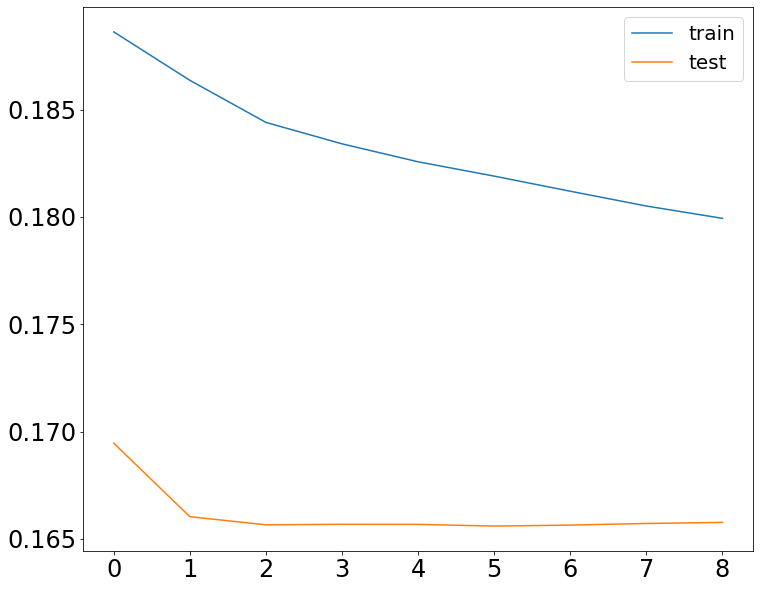

Epoch 00008: early stopping
Teste - Gráficos com lag 2
Treinamento - Gráficos com lag 2


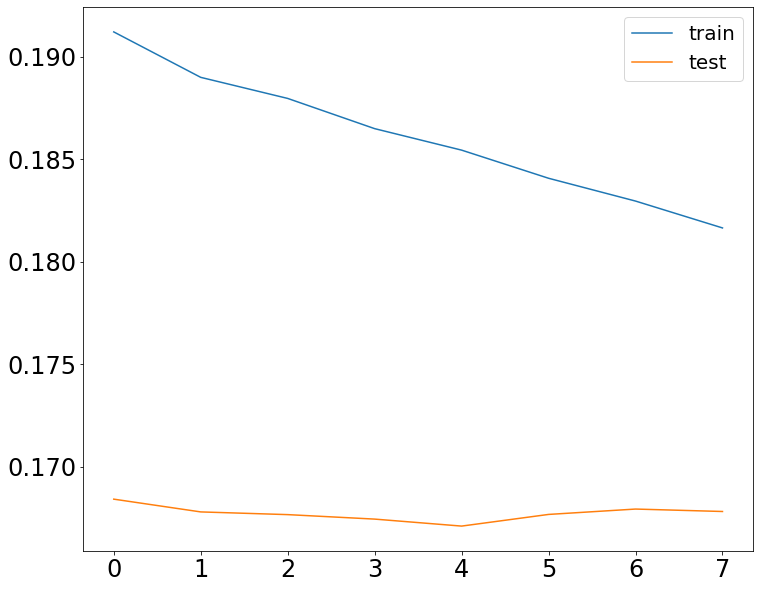

Epoch 00008: early stopping
Teste - Gráficos com lag 3
Treinamento - Gráficos com lag 3


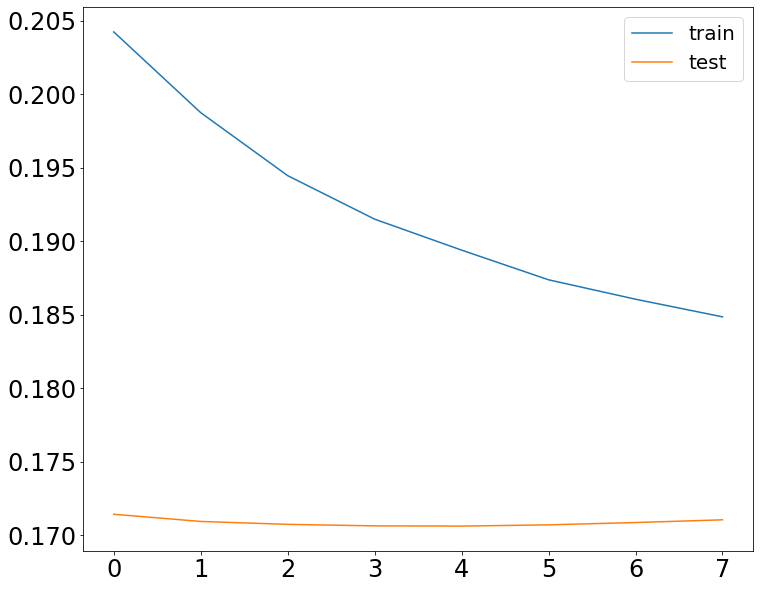

Epoch 00006: early stopping
Teste - Gráficos com lag 4
Treinamento - Gráficos com lag 4


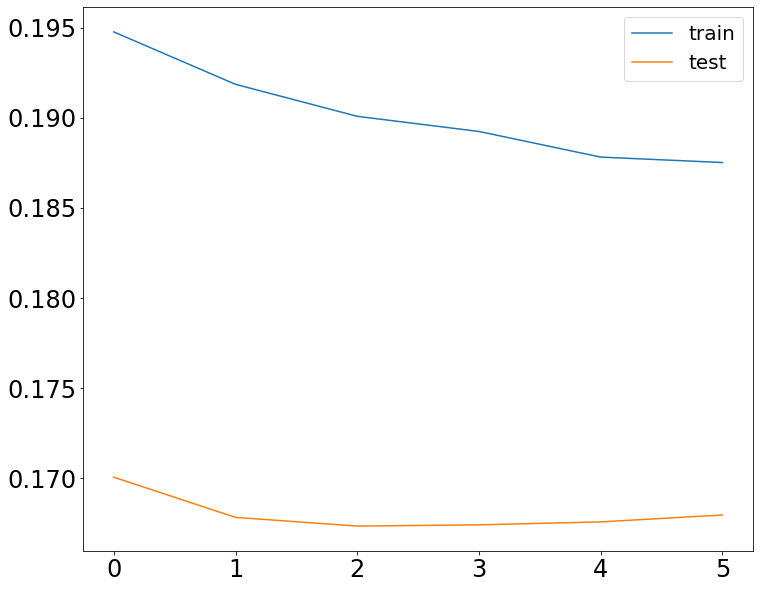

Epoch 00008: early stopping
Teste - Gráficos com lag 5
Treinamento - Gráficos com lag 5


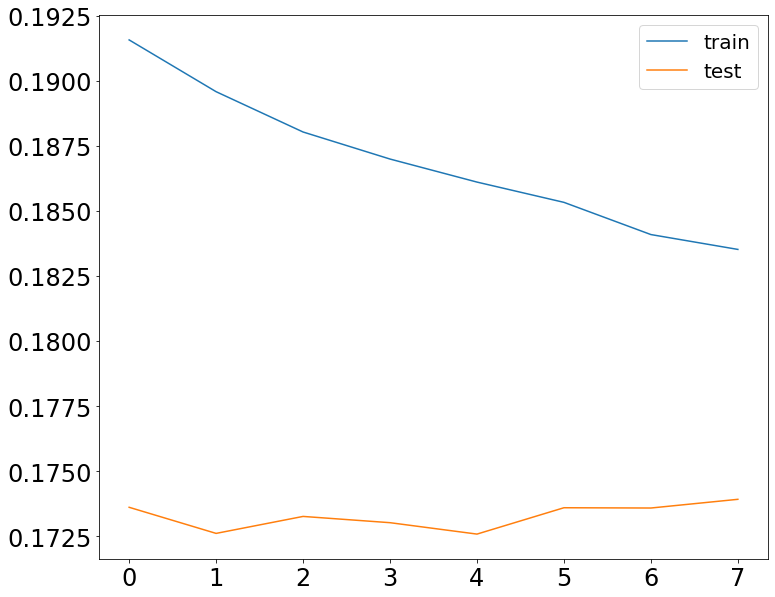

Epoch 00005: early stopping
Teste - Gráficos com lag 6
Treinamento - Gráficos com lag 6


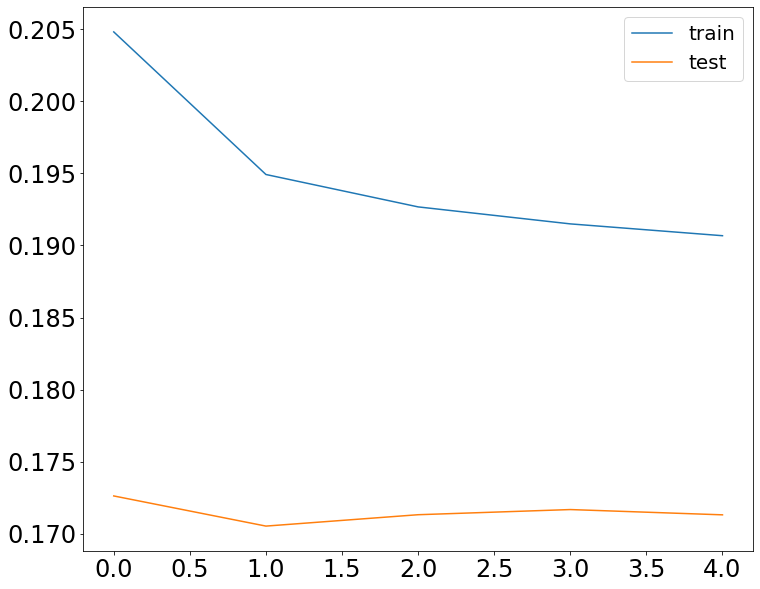

Epoch 00012: early stopping
Teste - Gráficos com lag 7
Treinamento - Gráficos com lag 7


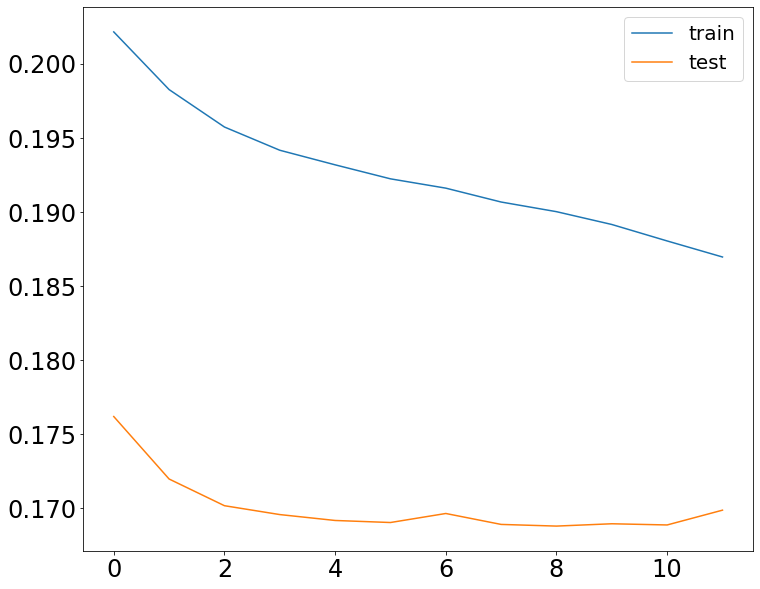

Epoch 00010: early stopping
Teste - Gráficos com lag 8
Treinamento - Gráficos com lag 8


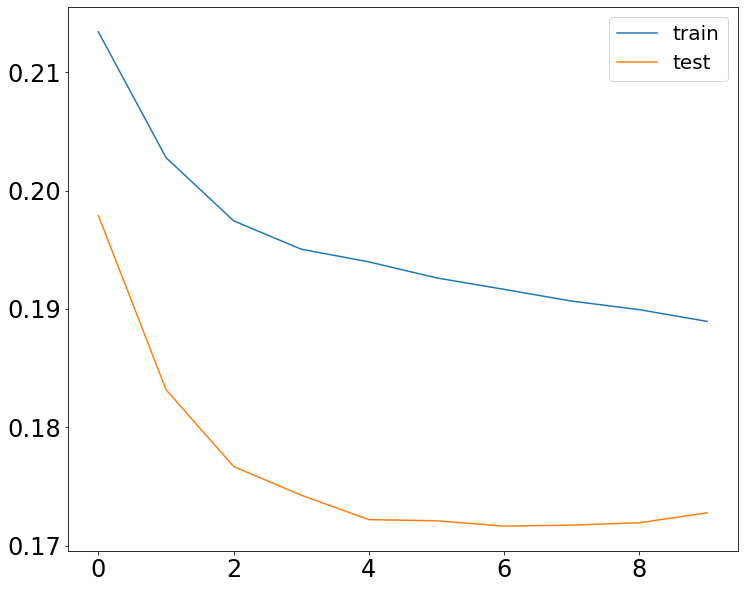

Epoch 00008: early stopping
Teste - Gráficos com lag 9
Treinamento - Gráficos com lag 9


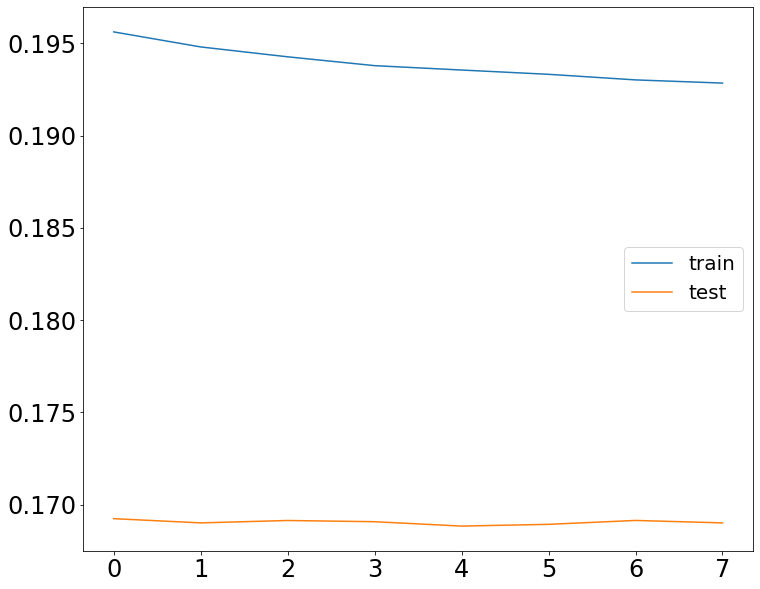

Epoch 00006: early stopping
Teste - Gráficos com lag 10
Treinamento - Gráficos com lag 10


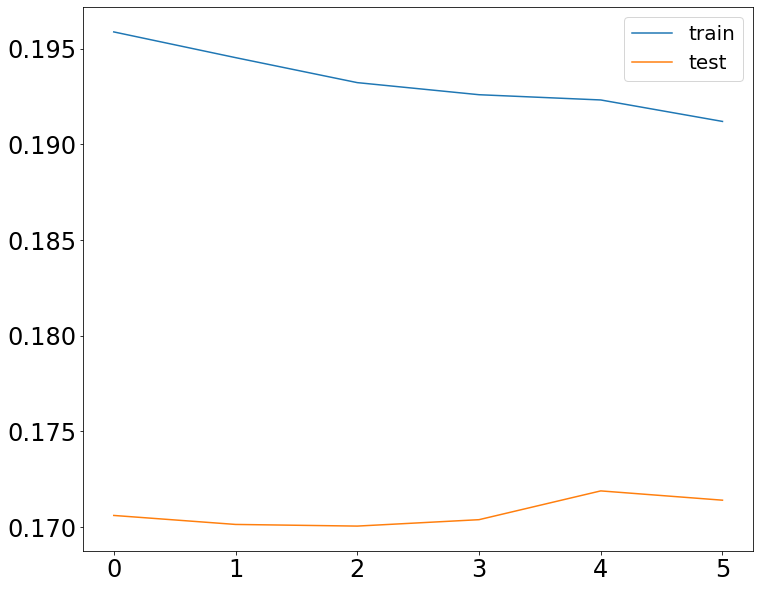

Epoch 00004: early stopping
Teste - Gráficos com lag 11
Treinamento - Gráficos com lag 11


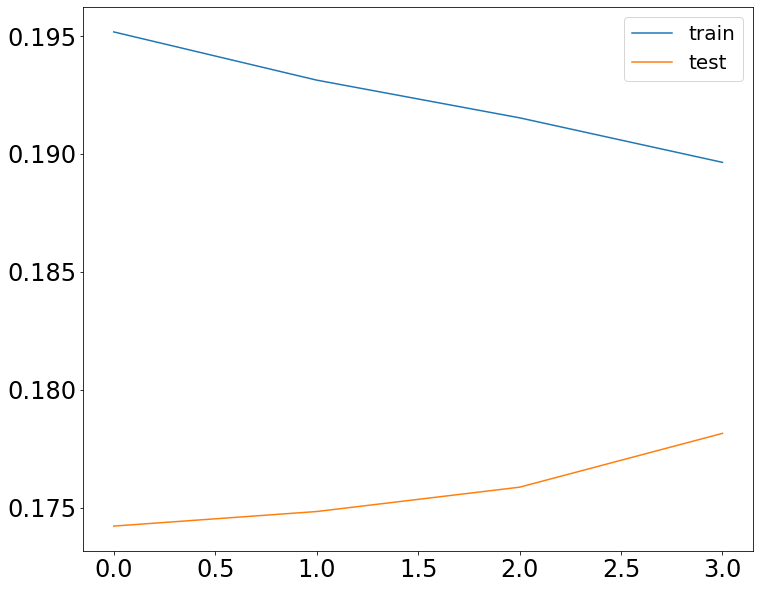

Epoch 00005: early stopping
Teste - Gráficos com lag 12
Treinamento - Gráficos com lag 12


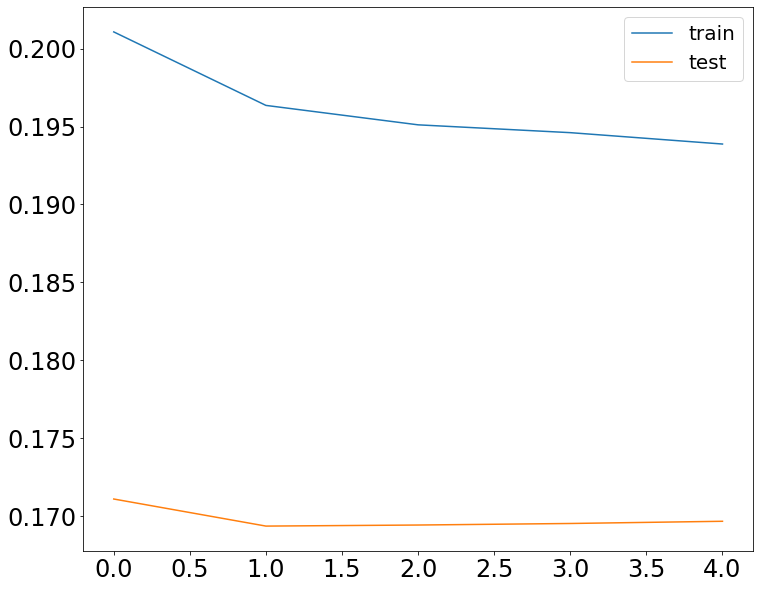

Epoch 00014: early stopping
Teste - Gráficos com lag 13
Treinamento - Gráficos com lag 13


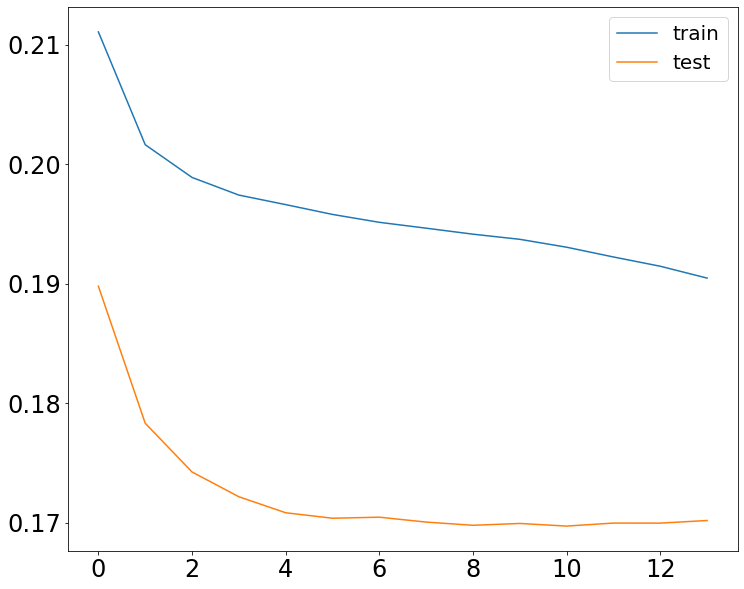

Epoch 00007: early stopping
Teste - Gráficos com lag 14
Treinamento - Gráficos com lag 14


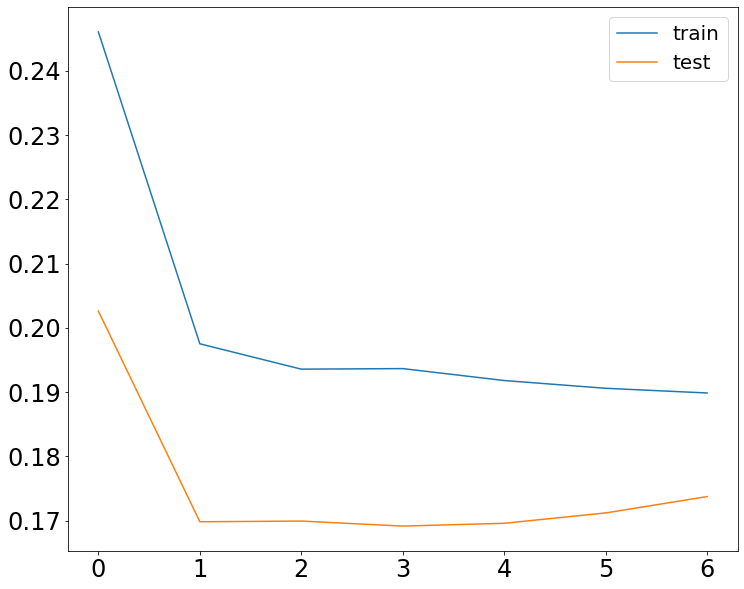

Epoch 00005: early stopping
Teste - Gráficos com lag 15
Treinamento - Gráficos com lag 15


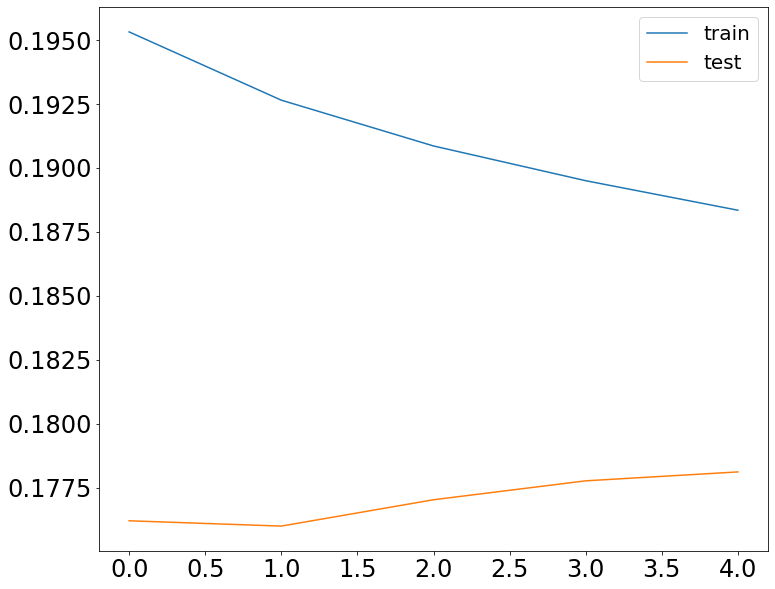

Epoch 00004: early stopping
Teste - Gráficos com lag 16
Treinamento - Gráficos com lag 16


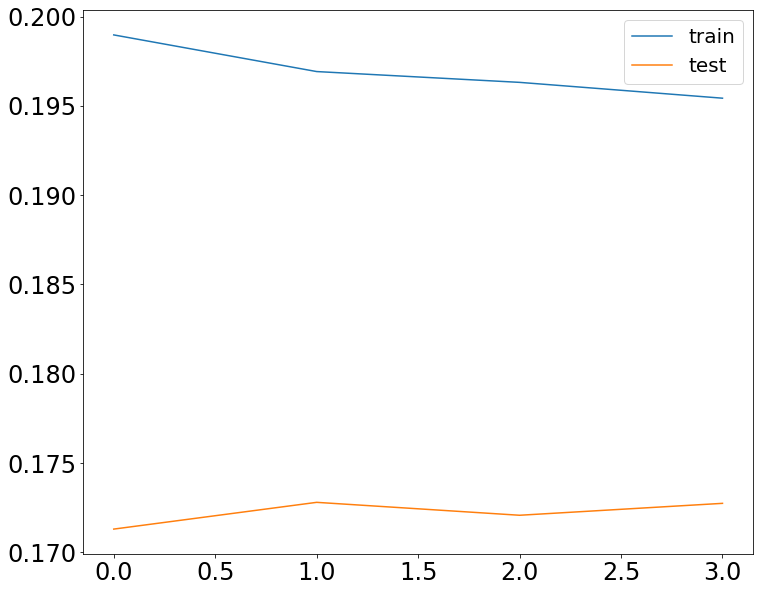

Epoch 00008: early stopping
Teste - Gráficos com lag 17
Treinamento - Gráficos com lag 17


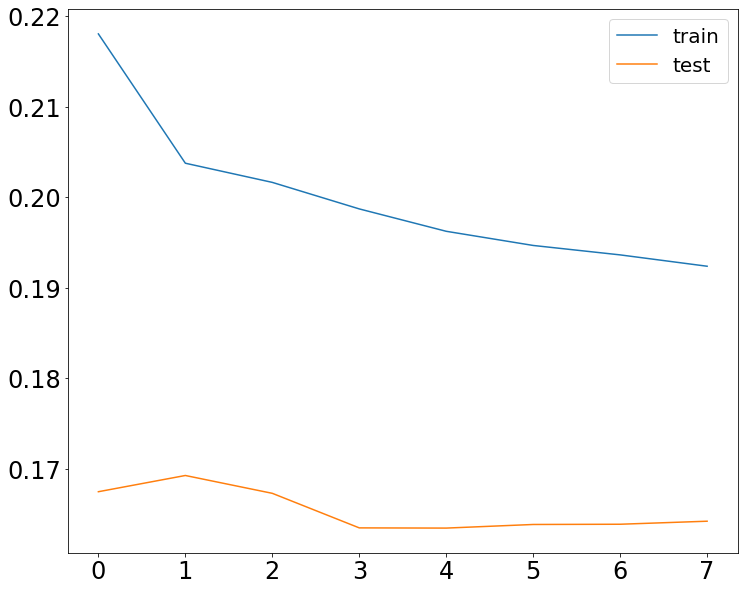

Epoch 00005: early stopping
Teste - Gráficos com lag 18
Treinamento - Gráficos com lag 18


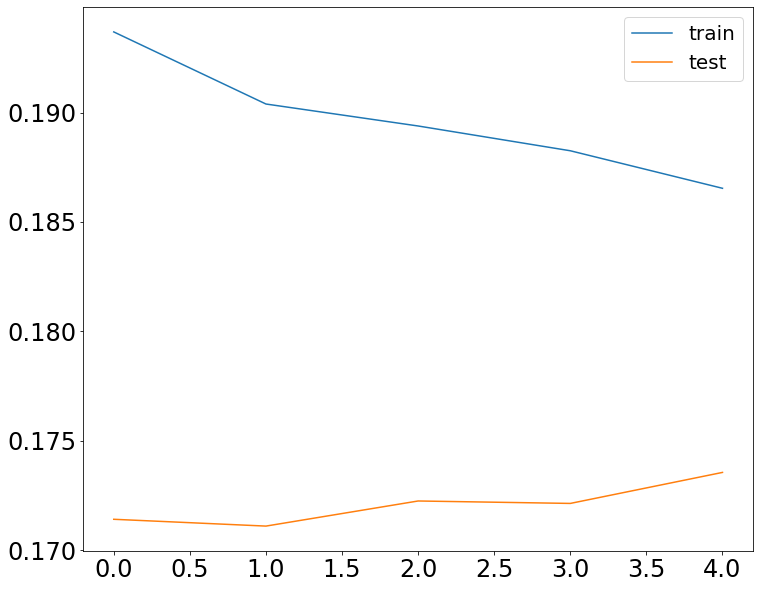

Epoch 00009: early stopping
Teste - Gráficos com lag 19
Treinamento - Gráficos com lag 19


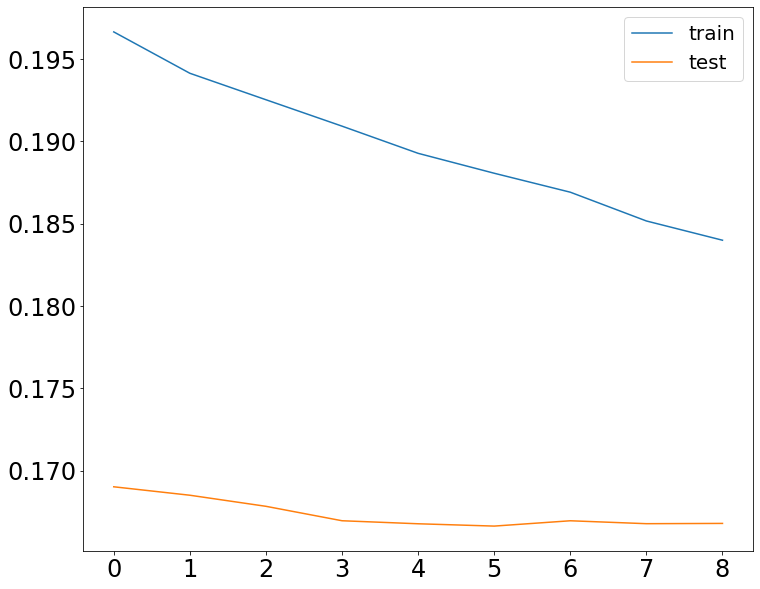

Epoch 00005: early stopping
Teste - Gráficos com lag 20
Treinamento - Gráficos com lag 20


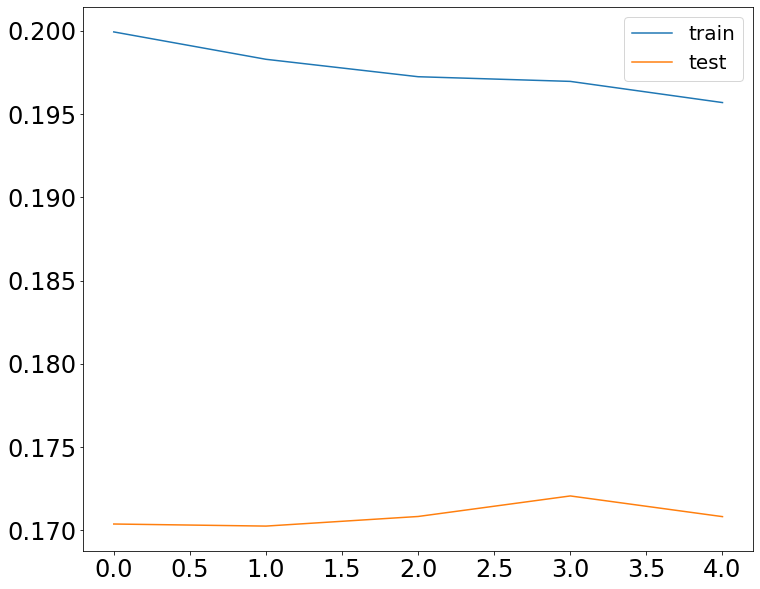

,lags_treino,mape_treino,rmse_treino,R_quad_treino,lags_teste,mape_teste,rmse_teste,R_quad_teste
count,20.00000,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000
mean,10.50000,48.014170,2.419490,0.018230,10.50000,43.845925,2.063035,0.005865
std,5.91608,0.941880,0.034568,0.016267,5.91608,1.154535,0.049320,0.006925
min,1.00000,46.384100,2.363000,0.000200,1.00000,42.139500,1.994600,0.000000
25%,5.75000,47.158175,2.393725,0.005600,5.75000,43.052125,2.024950,0.001400
50%,10.50000,47.988600,2.416650,0.016100,10.50000,43.770850,2.066400,0.002700
75%,15.25000,48.810350,2.446975,0.026300,15.25000,44.764025,2.084750,0.009750
max,20.00000,49.684300,2.483900,0.055500,20.00000,46.349600,2.172200,0.026700


In [10]:
df_resultado_medio_g = pd.DataFrame()

index_coluna = 0

parametro = []
tecnica   = []

#média
media_parametro_mape_treino = []
media_parametro_rmse_treino = []
media_parametro_r_treino    = []
    
media_parametro_mape_teste  = []
media_parametro_rmse_teste  = []
media_parametro_r_teste     = []
    
#desvio_padrão
    
std_parametro_mape_treino = []
std_parametro_rmse_treino = []
std_parametro_r_treino    = []
    
std_parametro_mape_teste  = []
std_parametro_rmse_teste  = []
std_parametro_r_teste     = []

for p in ('ph','coliformes', 'dbo','fosforo','od','solido','turbidez'):
    
    print('Agora é a vez do parâmetro:', p)
   
    ugrhi06,posicao_col06   = seleciona_colunas(df_ugrhi06,p,6)
    ugrhi10,posicao_col10   = seleciona_colunas(df_ugrhi10,p,10)
    #index_coluna10 = pega_index_coluna_ugrhi10(p)
          
    #index_coluna = index_coluna + 1

    df_resultados_treino = pd.DataFrame()
    df_resultados_teste  = pd.DataFrame()
    df_resultados        = pd.DataFrame()
    
    media_lag_mape_treino = []
    media_lag_rmse_treino = []
    media_lag_r_treino    = []
        
    media_lag_mape_teste = []
    media_lag_rmse_teste = []
    media_lag_r_teste    = []
    
    for l in range(1, 16):
    
        lags = l

        #seleciona os dados

        train06,train_previsao06, test06 = pegar_dados_coluna_predita_train_test(ugrhi06,0.70,posicao_col06) 
        train10,train_previsao10, test10 = pegar_dados_coluna_predita_train_test(ugrhi10,0.70,posicao_col10) 

        #normalização dos dados
        train06,test06,testd06 = normalizacao(train06,test06)
        train10,test10,testd10 = normalizacao(train10,test10)

        normalizador_previsao = MinMaxScaler()
        sc = MinMaxScaler()
        normalizador_previsao.fit_transform(train_previsao06)

        #Prepara os dados de treinamento -ugrhi06
        #Vai predizer o valor da coluna 4 (valor ph)
        train_X06, train_y06 = prepara_dados(train06, lags,posicao_col06)

        #Prepara os dados de teste - ugrhi06
        entradas06 = ugrhi06[len(ugrhi06) - len(test06) - lags:].values
        entradas06 = sc.fit_transform(entradas06)   

        test_X06 = []
        for i in range(lags, lags+len(test06)):
            test_X06.append(entradas06[i-lags:i, 0:posicao_col06+1])
        test_X06 = np.array(test_X06)

        #Ajusta a dimensão de test_X06 e train_X06
        n_input = train_X06.shape[1] * train_X06.shape[2]

        test_X06 = test_X06.reshape((test_X06.shape[0],n_input))

        train_X06 = train_X06.reshape((train_X06.shape[0],n_input))

        #Prepara os dados de treinamento -ugrhi06
        #Vai predizer o valor da coluna 4 (valor ph)
        train_X10, train_y10 = prepara_dados(train10, lags,posicao_col10)

        #Prepara os dados de teste - ugrhi10
        entradas10 = ugrhi10[len(ugrhi10) - len(test10) - lags:].values
        entradas10 = sc.fit_transform(entradas10)   

        test_X10 = []
        for i in range(lags, lags+len(test10)):
            test_X10.append(entradas10[i-lags:i, 0:posicao_col10+1])
        test_X10 = np.array(test_X10)

        #Ajusta a dimensão de test_X06 e train_X06
        n_input = train_X10.shape[1] * train_X10.shape[2]

        test_X10 = test_X10.reshape((test_X10.shape[0],n_input))

        train_X10 = train_X10.reshape((train_X10.shape[0],n_input))

        media_simulador_mape_treino = []
        media_simulador_rmse_treino = []
        media_simulador_r_treino    = []
            
        media_simulador_mape_teste  = []
        media_simulador_rmse_teste  = []
        media_simulador_r_teste     = []
        
        for r in range(0,6)

            #cria o modelo
            model = Sequential()
            model.add(Dense(units = 10, activation = 'relu', input_dim = n_input))
            model.add(Dense(units = 21, activation = 'relu'))
            model.add(Dense(units = 1, activation = 'sigmoid'))
            model.compile(loss = 'mean_absolute_error', optimizer = 'adam',
                          metrics = ['mean_absolute_error'])

            es = EarlyStopping(monitor='val_loss', patience = 3, verbose=0)


            #Treina o modelo
            history = model.fit(train_X06, train_y06, validation_data=(test_X10, test10), batch_size = 32, epochs = 2000, 
                                callbacks=[es], verbose=0)

            #Treina o modelo
            #model.fit(train_X06, train_y06, batch_size = 32, epochs = 100)

            #Dados de teste
            previsoes = model.predict(test_X10)
            #previsoes = previsoes.reshape(-1, 1)
            previsoes = normalizador_previsao.inverse_transform(previsoes)

            #print('Teste - Gráficos com lag', l)
            '''
            #Plotagem do gráfico
            plt.plot(testd10,color='red',label = 'Observado')
            plt.plot(previsoes,color='blue',label = 'Previsoes')
            plt.xlabel('Tempo')
            plt.ylabel('Valor pH')
            plt.legend()
            plt.show()
            '''

            #Dados de treino
            previsoes_treino = model.predict(train_X10)
            previsoes_treino = previsoes_treino.reshape(-1, 1)
            previsoes_treino = normalizador_previsao.inverse_transform(previsoes_treino)

            treino = train_previsao10[lags: len(previsoes_treino) + lags, :]
            observado_test = testd10

            observado_treino = train_previsao10  

            #print('Treinamento - Gráficos com lag', l)
            '''
            #Plotagem do gráfico
            plt.plot(train_previsao10,color='red',label = 'Observado')
            plt.plot(previsoes_treino,color='blue',label = 'Previsoes')
            plt.xlabel('Tempo')
            plt.ylabel('Valor pH')
            plt.legend()
            plt.show()
            '''

            treino         = ajusta_array(treino)
            observado_test = ajusta_array(observado_test)

            #Calculo do erro da previsão MAPE, RMSE e R²

            observado_treino_d = observado_treino
            previsoes_treino_d = previsoes_treino
            previsoes_d        = previsoes

            mape_treino_d        = round(mape(previsoes_treino,treino),4)
            rmse_treino_d        = round(rmse(previsoes_treino,treino),4)
            #r_treino_d           = round(r2(previsoes_treino,treino),4)

            mape_teste_d        = round(mape(previsoes,observado_test),4)
            rmse_teste_d        = round(rmse(previsoes,observado_test),4)
            #r_teste_d           = round(r2(previsoes,observado_test),4) 

            df_corr_determinacao_treino = pd.DataFrame()
            df_corr_determinacao_teste  = pd.DataFrame()

            #Calcula o coeficiente de determinação
            dict = {'previsao_treino': ajusta_lista(previsoes_treino), 'treino': ajusta_array(treino)}

            df_treino = pd.DataFrame(dict)
            dframes_treino = [df_corr_determinacao_treino,df_treino]
            df_corr_determinacao_treino = pd.concat(dframes_treino)

            dict = {'previsao_teste': ajusta_lista(previsoes), 'teste': ajusta_array(observado_test)} 

            df_teste = pd.DataFrame(dict)
            dframes_teste = [df_corr_determinacao_teste,df_teste]
            df_corr_determinacao_teste = pd.concat(dframes_teste)

            r_treino_d = []
            r_teste_d  = []

            r_treino_d.append(round(correlacao_determinacao(df_corr_determinacao_treino,0),4))
            r_teste_d.append(round(correlacao_determinacao(df_corr_determinacao_teste,1),4))
            
            media_simulador_mape_treino.append(np.mean(mape_treino_d))
            media_simulador_rmse_treino.append(np.mean(rmse_treino_d))
            media_simulador_r_treino.append(np.mean(r_treino_d))
            
            media_simulador_mape_teste.append(np.mean(mape_teste_d))
            media_simulador_rmse_teste.append(np.mean(rmse_teste_d))
            media_simulador_r_teste.append(np.mean(r_teste_d))
            
            
    
        media_lag_mape_treino.append(np.mean(media_simulador_mape_treino))
        media_lag_rmse_treino.append(np.mean(media_simulador_rmse_treino))
        media_lag_r_treino.append(np.mean(media_simulador_r_treino))
        
        media_lag_mape_teste.append(np.mean(media_simulador_mape_teste))
        media_lag_rmse_teste.append(np.mean(media_simulador_rmse_teste))
        media_lag_r_teste.append(np.mean(media_simulador_r_teste))
        
                
    #média
    media_parametro_mape_treino.append(np.mean(media_lag_mape_treino))
    media_parametro_rmse_treino.append(np.mean(media_lag_rmse_treino))
    media_parametro_r_treino.append(np.mean(media_lag_r_treino))
    
    media_parametro_mape_teste.append(np.mean(media_lag_mape_teste))
    media_parametro_rmse_teste.append(np.mean(media_lag_rmse_teste))
    media_parametro_r_teste.append(np.mean(media_lag_r_teste))
        
    #desvio_padrão
    
    #std_parametro_mape_treino.append(np.std(media_lag_mape_treino))
    std_parametro_rmse_treino.append(np.std(media_lag_rmse_treino))
    #std_parametro_r_treino.append(np.std(media_lag_r_treino))
    
    #std_parametro_mape_teste.append(np.std(media_lag_mape_teste))
    std_parametro_rmse_teste.append(np.std(media_lag_rmse_teste))
    #std_parametro_r_teste.append(np.std(media_lag_r_teste))
        
    parametro.append(p)
    tecnica.append('MLP (Var. selec.)')
    
dict = {'parametro': parametro,
        'mape_treino':  media_parametro_mape_treino,  
        'rmse_treino':  media_parametro_rmse_treino, 'std_rmse_treino':  std_parametro_rmse_treino,
        'r_quad_treino':media_parametro_r_treino,    
        'mape_teste':   media_parametro_mape_teste,   
        'rmse_teste':   media_parametro_rmse_teste,  'std_rmse_teste':   std_parametro_rmse_teste,
        'r_quad_teste': media_parametro_r_teste}
   
df_resultado_final = pd.DataFrame(dict)

dframes = [df_resultado_medio_g,df_resultado_final]
df_resultado_medio_g = pd.concat(dframes)

df_resultado_medio_g.round(2)

In [ ]:
df_resultado_medio_g.round(2).to_csv (r'C:\Users\Anderson\predicaoagua\src\src_dissertação\resultados\mlp_espaco_temporal_var_selec.csv', index = True, header=True)